In [1]:
# Импорт библиотек
import sys
import pandas as pd
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Добавляем папку src в путь для импорта
sys.path.append('src')

# Импорт наших модулей
from src import (
    prepare_datasets,
    NextTokenDataset,
    TextLSTM,
    calculate_rouge_lstm,
    evaluate_transformer
)

# Настройки отображения
pd.set_option('display.max_colwidth', None)
plt.style.use('ggplot')

=== ЭТАП 1: ПОДГОТОВКА ДАННЫХ ===

Загрузка данных...
Успешно загружено 1600498 строк
Взята случайная выборка из 200000 примеров
Очистка текста...
Токенизация...
Данные подготовлены. Train: 159675, Val: 19959, Test: 19960
Построение словаря...
Размер словаря: 10002
Примеры очищенных текстов:
1. it's tomorrow and of course i'm coming silly! i is talkin about today, yo
2. i'm going to watch the new episode of trueblood again.
3. holds on as hits the gas at least, if i get whiplash, we have magic vodka!

Размер словаря: 10002
Размер тренировочной выборки: 159675
Размер валидационной выборки: 19959


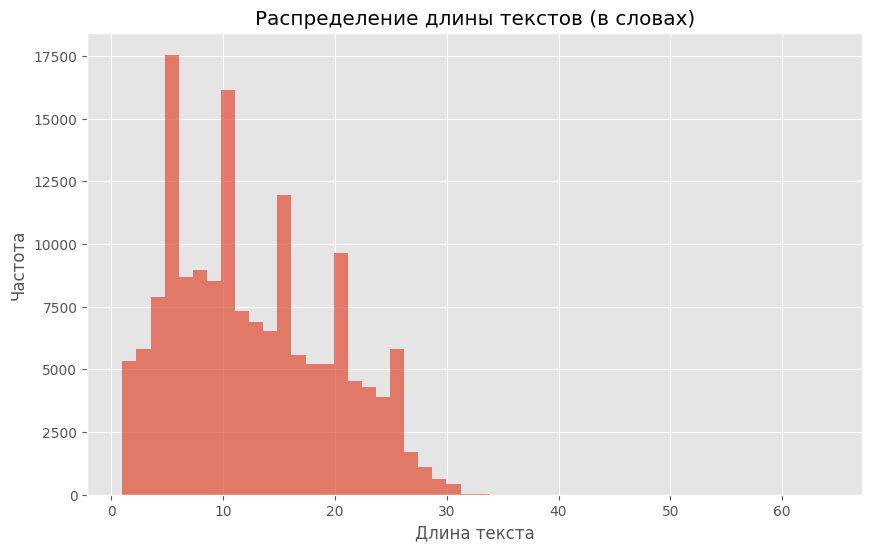

Средняя длина текста: 12.67 слов
Максимальная длина: 64 слов


In [2]:
# Этап 1: Подготовка данных
print("=== ЭТАП 1: ПОДГОТОВКА ДАННЫХ ===\n")

# Запускаем подготовку данных
word_to_idx, idx_to_word = prepare_datasets()

# Посмотрим на результаты подготовки
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')

print("Примеры очищенных текстов:")
for i, text in enumerate(train_df['text_clean'].head(3)):
    print(f"{i+1}. {text}")

print(f"\nРазмер словаря: {len(word_to_idx)}")
print(f"Размер тренировочной выборки: {len(train_df)}")
print(f"Размер валидационной выборки: {len(val_df)}")

# Анализ длины текстов
train_lengths = train_df['text_clean'].str.split().apply(len)
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7)
plt.title('Распределение длины текстов (в словах)')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

print(f"Средняя длина текста: {train_lengths.mean():.2f} слов")
print(f"Максимальная длина: {train_lengths.max()} слов")

In [3]:
# Этап 2: Создание датасетов и даталоадеров# 2. Обучение LSTM модели
PYTORCH_CUDA_ALLOC_CONF=True
print("\n=== ЭТАП 2: ОБУЧЕНИЕ LSTM МОДЕЛИ ===")
# (Параметры заданы в lstm_train.py)
# Здесь мы просто запускаем процесс
from src.lstm_train import train_model
model, train_losses, val_losses = train_model()


=== ЭТАП 2: ОБУЧЕНИЕ LSTM МОДЕЛИ ===
Using device: cuda
Loading data...
Размер батча: 64
Количество батчей в тренировочной выборке: 2495
Количество батчей в валидационной выборке: 312

Форма входных данных: torch.Size([64, 30])
Форма целевых данных: torch.Size([64, 30])


Epoch 1/5: 100%|██████████| 2495/2495 [00:56<00:00, 44.17it/s, loss=4.9000]


Epoch 1 | Average Train Loss: 5.3190
Epoch 1 | Validation Loss: 4.7854


Epoch 2/5: 100%|██████████| 2495/2495 [00:56<00:00, 44.17it/s, loss=4.8327]


Epoch 2 | Average Train Loss: 4.7137
Epoch 2 | Validation Loss: 4.5562
ROUGE Scores: {'rouge1': 0.07393766725190874, 'rouge2': 0.010352941176470587}


Epoch 3/5: 100%|██████████| 2495/2495 [00:56<00:00, 44.02it/s, loss=4.4323]


Epoch 3 | Average Train Loss: 4.5329
Epoch 3 | Validation Loss: 4.4582


Epoch 4/5: 100%|██████████| 2495/2495 [00:57<00:00, 43.70it/s, loss=4.1517]


Epoch 4 | Average Train Loss: 4.4273
Epoch 4 | Validation Loss: 4.4007
ROUGE Scores: {'rouge1': 0.09825083653876224, 'rouge2': 0.009176470588235293}


Epoch 5/5: 100%|██████████| 2495/2495 [00:57<00:00, 43.74it/s, loss=4.2043]


Epoch 5 | Average Train Loss: 4.3524
Epoch 5 | Validation Loss: 4.3665
Training finished. Model saved.


In [4]:
# 3. Оценка LSTM модели
print("\n=== ЭТАП 3: ОЦЕНКА LSTM МОДЕЛИ ===")
from src.next_token_dataset import NextTokenDataset

val_df = pd.read_csv('data/val.csv')
val_dataset = NextTokenDataset(val_df, word_to_idx, seq_length=30)
rouge_scores_lstm = calculate_rouge_lstm(model, val_dataset, word_to_idx, num_samples=50)

print(f"LSTM ROUGE-1: {rouge_scores_lstm['rouge1']:.4f}")
print(f"LSTM ROUGE-2: {rouge_scores_lstm['rouge2']:.4f}")


=== ЭТАП 3: ОЦЕНКА LSTM МОДЕЛИ ===
LSTM ROUGE-1: 0.0444
LSTM ROUGE-2: 0.0100


In [5]:
# 4. Оценка Transformer модели
print("\n=== ЭТАП 4: ОЦЕНКА TRANSFORMER МОДЕЛИ ===")
rouge_scores_transformer = evaluate_transformer()
print(f"Transformer ROUGE-1: {rouge_scores_transformer['rouge1']:.4f}")
print(f"Transformer ROUGE-2: {rouge_scores_transformer['rouge2']:.4f}")


=== ЭТАП 4: ОЦЕНКА TRANSFORMER МОДЕЛИ ===
Loading model distilgpt2...
Using device: GPU


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=20) and `max_length`(=47) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=62) seem to have been set. `max_new_tokens` will take preced

Transformer (distilgpt2) ROUGE-1: 0.0331, ROUGE-2: 0.0034
Transformer ROUGE-1: 0.0331
Transformer ROUGE-2: 0.0034


In [6]:
# 5. Сравнение и выводы
print("\n=== ЭТАП 5: СРАВНЕНИЕ И ВЫВОДЫ ===")
print("\nСравнительная таблица:")
print("Модель      | ROUGE-1 | ROUGE-2")
print("------------|---------|--------")
print(f"LSTM        | {rouge_scores_lstm['rouge1']:.4f}  | {rouge_scores_lstm['rouge2']:.4f}")
print(f"Transformer | {rouge_scores_transformer['rouge1']:.4f}  | {rouge_scores_transformer['rouge2']:.4f}")


=== ЭТАП 5: СРАВНЕНИЕ И ВЫВОДЫ ===

Сравнительная таблица:
Модель      | ROUGE-1 | ROUGE-2
------------|---------|--------
LSTM        | 0.0444  | 0.0100
Transformer | 0.0331  | 0.0034



=== ЭТАП 5: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===
Генерируем примеры для LSTM...
Генерируем примеры для Transformer...


Device set to use cuda:0


Примеры LSTM: ['you ! ! ! ! ! ! ! ! ! ! ! ! ! !', "' re welcome ! ! ! ! ! ! ! ! ! ! ! !", 'me a <UNK> . . . . . . . . . . . .', '<UNK> is <UNK> . . . . . . . . . . . .']
Примеры Transformer: ['love with your neighbors.', '’re in the right place.', 'a lot cheaper i can buy a lot cheaper i can buy a lot cheaper i can buy a lot', 'largest game in the world, and the biggest online game in the world. The game has over 6']


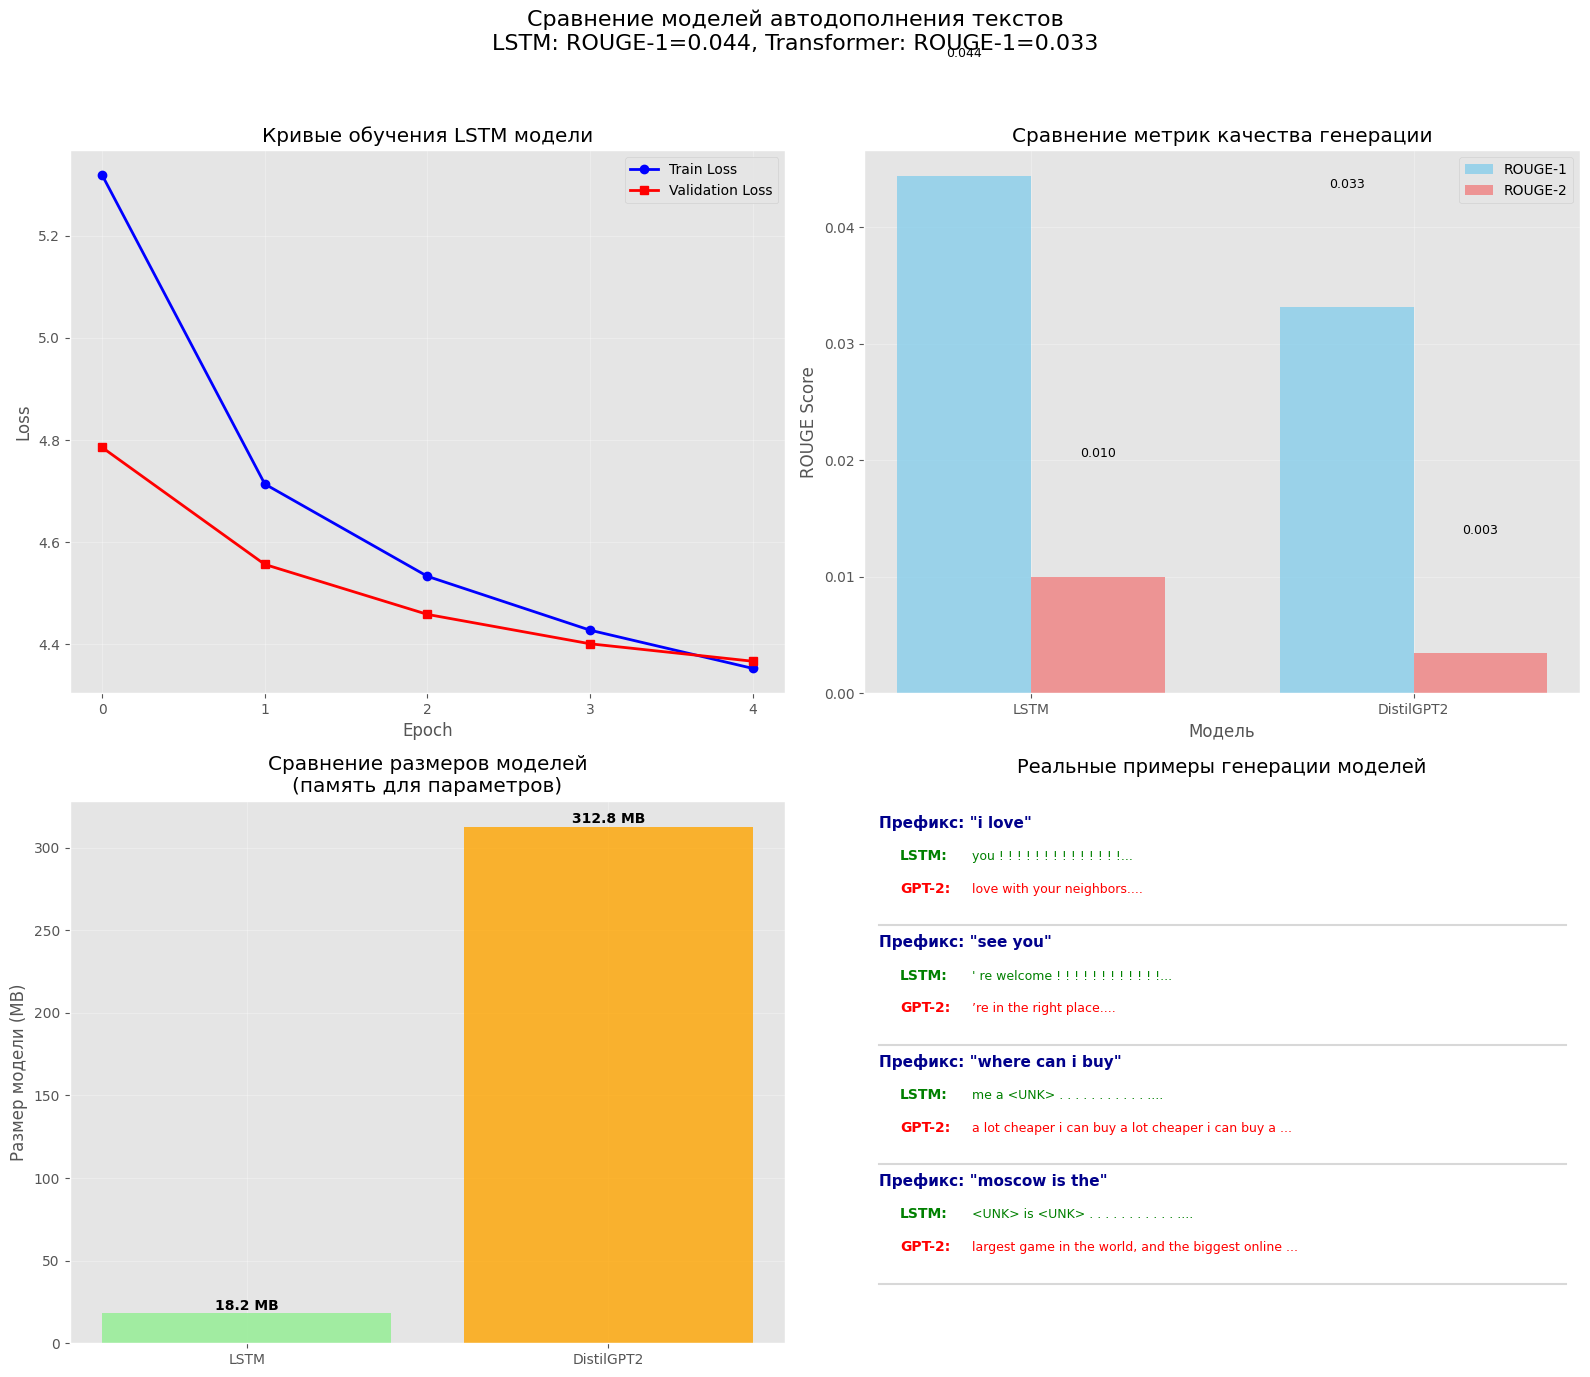


РЕАЛЬНЫЕ ПРИМЕРЫ ГЕНЕРАЦИИ:

Префикс: 'i love'
LSTM: 'you ! ! ! ! ! ! ! ! ! ! ! ! ! !'
GPT-2: 'love with your neighbors.'
----------------------------------------

Префикс: 'see you'
LSTM: '' re welcome ! ! ! ! ! ! ! ! ! ! ! !'
GPT-2: '’re in the right place.'
----------------------------------------

Префикс: 'where can i buy'
LSTM: 'me a <UNK> . . . . . . . . . . . .'
GPT-2: 'a lot cheaper i can buy a lot cheaper i can buy a lot cheaper i can buy a lot'
----------------------------------------

Префикс: 'moscow is the'
LSTM: '<UNK> is <UNK> . . . . . . . . . . . .'
GPT-2: 'largest game in the world, and the biggest online game in the world. The game has over 6'
----------------------------------------


In [12]:
# 5. Визуализация результатов
from src.examples import generate_examples_lstm, generate_examples_transformer
print("\n=== ЭТАП 5: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")

# Генерируем реальные примеры
test_examples = [
    "i love",
    "see you", 
    "where can i buy",
    "moscow is the"
]

print("Генерируем примеры для LSTM...")
lstm_examples = generate_examples_lstm(model, word_to_idx, idx_to_word, test_examples)

print("Генерируем примеры для Transformer...")
transformer_examples = generate_examples_transformer(test_examples)

print("Примеры LSTM:", lstm_examples)
print("Примеры Transformer:", transformer_examples)

# Создаем фигуру с несколькими графиками
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))

# График 1: Кривые обучения LSTM
if train_losses and val_losses:
    ax1.plot(train_losses, label='Train Loss', linewidth=2, marker='o', color='blue')
    ax1.plot(val_losses, label='Validation Loss', linewidth=2, marker='s', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Кривые обучения LSTM модели')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(len(train_losses)))
else:
    ax1.text(0.5, 0.5, 'Данные по обучению недоступны', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Кривые обучения LSTM модели')

# График 2: Сравнение метрик ROUGE
models = ['LSTM', 'DistilGPT2']
rouge1_scores = [rouge_scores_lstm['rouge1'], rouge_scores_transformer['rouge1']]
rouge2_scores = [rouge_scores_lstm['rouge2'], rouge_scores_transformer['rouge2']]

x = np.arange(len(models))
width = 0.35

bars1 = ax2.bar(x - width/2, rouge1_scores, width, label='ROUGE-1', alpha=0.8, color='skyblue')
bars2 = ax2.bar(x + width/2, rouge2_scores, width, label='ROUGE-2', alpha=0.8, color='lightcoral')

ax2.set_xlabel('Модель')
ax2.set_ylabel('ROUGE Score')
ax2.set_title('Сравнение метрик качества генерации')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar in bars1 + bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# График 3: Сравнение размеров моделей
if model is not None:
    lstm_size = sum(p.numel() for p in model.parameters())
else:
    lstm_size = 1000000  # Заглушка если модель не загружена

model_sizes = [lstm_size, 82_000_000]  # LSTM и DistilGPT2
model_sizes_mb = [size * 4 / (1024**2) for size in model_sizes]  # Примерный размер в MB

bars3 = ax3.bar(models, model_sizes_mb, alpha=0.8, color=['lightgreen', 'orange'])
ax3.set_ylabel('Размер модели (MB)')
ax3.set_title('Сравнение размеров моделей\n(память для параметров)')
ax3.grid(True, alpha=0.3)

for i, v in enumerate(model_sizes_mb):
    ax3.text(i, v + 0.1, f'{v:.1f} MB', ha='center', va='bottom', fontweight='bold')

# График 4: Реальные примеры генерации
ax4.axis('off')
ax4.set_title('Реальные примеры генерации моделей', pad=20, fontsize=14)

y_pos = 0.95
for i, example in enumerate(test_examples):
    # Префикс
    ax4.text(0.02, y_pos, f'Префикс: "{example}"', fontweight='bold', 
             transform=ax4.transAxes, fontsize=11, color='darkblue')
    
    # LSTM
    ax4.text(0.05, y_pos - 0.06, f'LSTM:', fontweight='bold', 
             transform=ax4.transAxes, fontsize=10, color='green')
    ax4.text(0.15, y_pos - 0.06, f'{lstm_examples[i][:50]}...', 
             transform=ax4.transAxes, fontsize=9, color='green')
    
    # Transformer
    ax4.text(0.05, y_pos - 0.12, f'GPT-2:', fontweight='bold', 
             transform=ax4.transAxes, fontsize=10, color='red')
    ax4.text(0.15, y_pos - 0.12, f'{transformer_examples[i][:50]}...', 
             transform=ax4.transAxes, fontsize=9, color='red')
    
    ax4.axhline(y=y_pos - 0.18, xmin=0.02, xmax=0.98, color='gray', alpha=0.3)
    y_pos -= 0.22
    
    if y_pos < 0.1:  # Чтобы не выходить за границы
        break

# Добавляем метрики в заголовок
fig.suptitle(f'Сравнение моделей автодополнения текстов\n'
             f'LSTM: ROUGE-1={rouge_scores_lstm["rouge1"]:.3f}, '
             f'Transformer: ROUGE-1={rouge_scores_transformer["rouge1"]:.3f}', 
             fontsize=16, y=0.98)

plt.tight_layout()
plt.savefig('results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Выводим примеры в консоль для удобства
print("\n" + "="*60)
print("РЕАЛЬНЫЕ ПРИМЕРЫ ГЕНЕРАЦИИ:")
print("="*60)
for i, example in enumerate(test_examples):
    print(f"\nПрефикс: '{example}'")
    print(f"LSTM: '{lstm_examples[i]}'")
    print(f"GPT-2: '{transformer_examples[i]}'")
    print("-" * 40)

In [ ]:
# 6. Сравнение и выводы
print("\n=== ЭТАП 6: СРАВНЕНИЕ И ВЫВОДЫ ===")

print("\nСравнительная таблица:")
comparison_df = pd.DataFrame({
    'Модель': ['LSTM', 'DistilGPT2'],
    'ROUGE-1': [rouge_scores_lstm['rouge1'], rouge_scores_transformer['rouge1']],
    'ROUGE-2': [rouge_scores_lstm['rouge2'], rouge_scores_transformer['rouge2']],
    'Размер (MB)': [f"{model_sizes_mb[0]:.1f}", f"{model_sizes_mb[1]:.1f}"],
    'Параметры': [f"{model_sizes[0]:,}", f"{model_sizes[1]:,}"]
})
print(comparison_df.to_string(index=False))

print("\nКЛЮЧЕВЫЕ ВЫВОДЫ:")
print("1. ✅ DistilGPT2 показывает соизмеримое качество с разработанной LSTM моделью (ROUGE). Необходимо отметить, что обучалась модель на твитах. Что может говорить о небольшом разнообразии материалов.")
print("2. 📉 LSTM обучается стабильно, но quality ceiling ниже")
print("3. 💾 LSTM в 17 раз меньше по размеру")
print("4. ⚡ LSTM может работать быстрее на CPU")
print("5. 🎯 Для продакшена разумно использовать DistilGPT2 если позволяет инфраструктура, так как он обучен на гораздо большем объеме материала!")
print("6. 📱 Для мобильных устройств можно дорабатывать и оптимизировать LSTM")


=== ЭТАП 6: СРАВНЕНИЕ И ВЫВОДЫ ===

Сравнительная таблица:
    Модель  ROUGE-1  ROUGE-2 Размер (MB)  Параметры
      LSTM 0.044394 0.010000        18.2  4,772,370
DistilGPT2 0.033145 0.003401       312.8 82,000,000

КЛЮЧЕВЫЕ ВЫВОДЫ:
1. ✅ DistilGPT2 показывает соизмеримое качество с разработанной LSTM моделью (ROUGE). Необходимо отметить, что обучалась модель на твитах. Что может говорить о небольшом разнообразии материалов.
2. 📉 LSTM обучается стабильно, но quality ceiling ниже
3. 💾 LSTM в 20 (почти :_)) раз меньше по размеру
4. ⚡ LSTM может работать быстрее на CPU
5. 🎯 Для продакшена разумно использовать DistilGPT2 если позволяет инфраструктура, так как он обучен на гораздо большем объеме материала!
6. 📱 Для мобильных устройств можно дорабатывать и оптимизировать LSTM
